## ***GraphMask***


> Moduled: Accpeting the four GNNs (GCN+GAP, DGCNN, DIFFPOOL, and GIN)


---

In [ ]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-lgbhtque
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-lgbhtque
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 7d0fcd2a6206ecabfa093bc260dbff042888ec6f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
import math

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from torch.nn import ReLU, Sequential
from torch import sigmoid
from itertools import chain
from time import perf_counter
import csv



from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [ ]:
Explainability_name = 'GraphMask'
Task_name = 'Graph Classification'

checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

#File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [ ]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

mutag_train_dataset = []
mutag_test_dataset = []
for index in read_training_list_indexes:
    mutag_train_dataset.append(mutag_dataset[index])
for index in read_test_list_indexes:
    mutag_test_dataset.append(mutag_dataset[index])


print(f'Number of training graphs: {len(mutag_train_dataset)}')
print(f'Number of test graphs: {len(mutag_test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [ ]:
BATCH_SIZE = 64
mutag_train_dataloader = DataLoader(mutag_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
mutag_test_dataloader = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)

In [ ]:
from torch_geometric.datasets import FakeDataset

num_graphs = 100
avg_num_nodes = 20
avg_degree = 15
node_feat_dim = 13
edge_feat_dim = 0
num_classes = 3

fake_dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
                           edge_dim=edge_feat_dim, num_classes=num_classes,)
Explainability_name = 'GraphMask'
Task_name = 'Graph Classification'
classifier_bias = True
DataSet_name = "Fake"
BATCH_SIZE = 10
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6

train_ratio = 0.8

fake_train_dataset = fake_dataset[:int(len(fake_dataset) * train_ratio)]
fake_test_dataset = fake_dataset[len(fake_dataset) - int(len(fake_dataset) * train_ratio):]

fake_train_dataloader = DataLoader(fake_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
fake_test_dataloader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=13, hidden_dim=13, output_dim=3,
                                       num_hid_layers=3, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, node_feat_size=7, mlp_act_fun='ReLu',
#                                    dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=17,
#                                    hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

#import DIFFPOOL as diffpool_model
#GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, num_classes=2, embedding_num_block_layers=1, embedding_hid_dim=64,
#                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
#                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
#                                          concat_neighborhood=False, Weight_Initializer=1, Bias=classifier_bias, dropout_rate=0,
#                                          normalize_graphsage=False, aggregation="mean", act_fun="ReLu", num_pooling=1,
#                                          concat_diffpools_outputs=True, pooling="mean")


#import GIN as gin_model
#GNN_Model = gin_model.GIN_Model(mlp_output_dim=2, mlp_input_dim=7, mlp_hid_dim=7, num_mlp_layers=4,
#                                Bias=classifier_bias, mlp_act_fun="ReLu", dropout_rate=classifier_dropout, num_slp_layers=2,
#                                Weight_Initializer=1, joint_embeddings=False)


Model_name = GNN_Model.__class__.__name__
print("Model_name: ", Model_name)
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

GCN_plus_GAP Input_Dimension: 13
GCN_plus_GAP Hidden_Dimension: 13
GCN_plus_GAP Output_Dimension: 3
GCN_plus_GAP Number_of_Hidden_Layers: 3
ReLu is Selected.
Model_name:  GCN_plus_GAP


In [ ]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [ ]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [ ]:
def train_step(data):
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in data:
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            batch_loss = loss_calculations(soft, batch_of_graphs.y)
            Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
            Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, prediction_output_before_soft, prediction_output = GNN_Model(batch_of_graphs, None)
            Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
            batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
            Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [ ]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index, data):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step(data)
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
        #  torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 1.0888
Epoch: 002, Model Loss: 1.0546
Epoch: 003, Model Loss: 1.0260
Epoch: 004, Model Loss: 0.9938
Epoch: 005, Model Loss: 0.9755
Epoch: 006, Model Loss: 0.9707
Epoch: 007, Model Loss: 0.9622
Epoch: 008, Model Loss: 0.9501
Epoch: 009, Model Loss: 0.9418
Epoch: 010, Model Loss: 0.9314
Epoch: 011, Model Loss: 0.9199
Epoch: 012, Model Loss: 0.9160
Epoch: 013, Model Loss: 0.9087
Epoch: 014, Model Loss: 0.8825
Epoch: 015, Model Loss: 0.8825
Epoch: 016, Model Loss: 0.8636
Epoch: 017, Model Loss: 0.8422
Epoch: 018, Model Loss: 0.8336
Epoch: 019, Model Loss: 0.8245
Epoch: 020, Model Loss: 0.7943
Epoch: 021, Model Loss: 0.7925
Epoch: 022, Model Loss: 0.7723
Epoch: 023, Model Loss: 0.7661
Epoch: 024, Model Loss: 0.7614
Epoch: 025, Model Loss: 0.7520
Epoch: 026, Model Loss: 0.7305
Epoch: 027, Model Loss: 0.7472
Epoch: 028, Model Loss: 0.7787
Epoch: 029, Model Loss: 0.7349
Epoch: 030, Model Loss: 0.7379
Epoch: 031, Model Loss: 0.7084
Epoch: 032, Model Loss: 0.7266
Epoch: 0

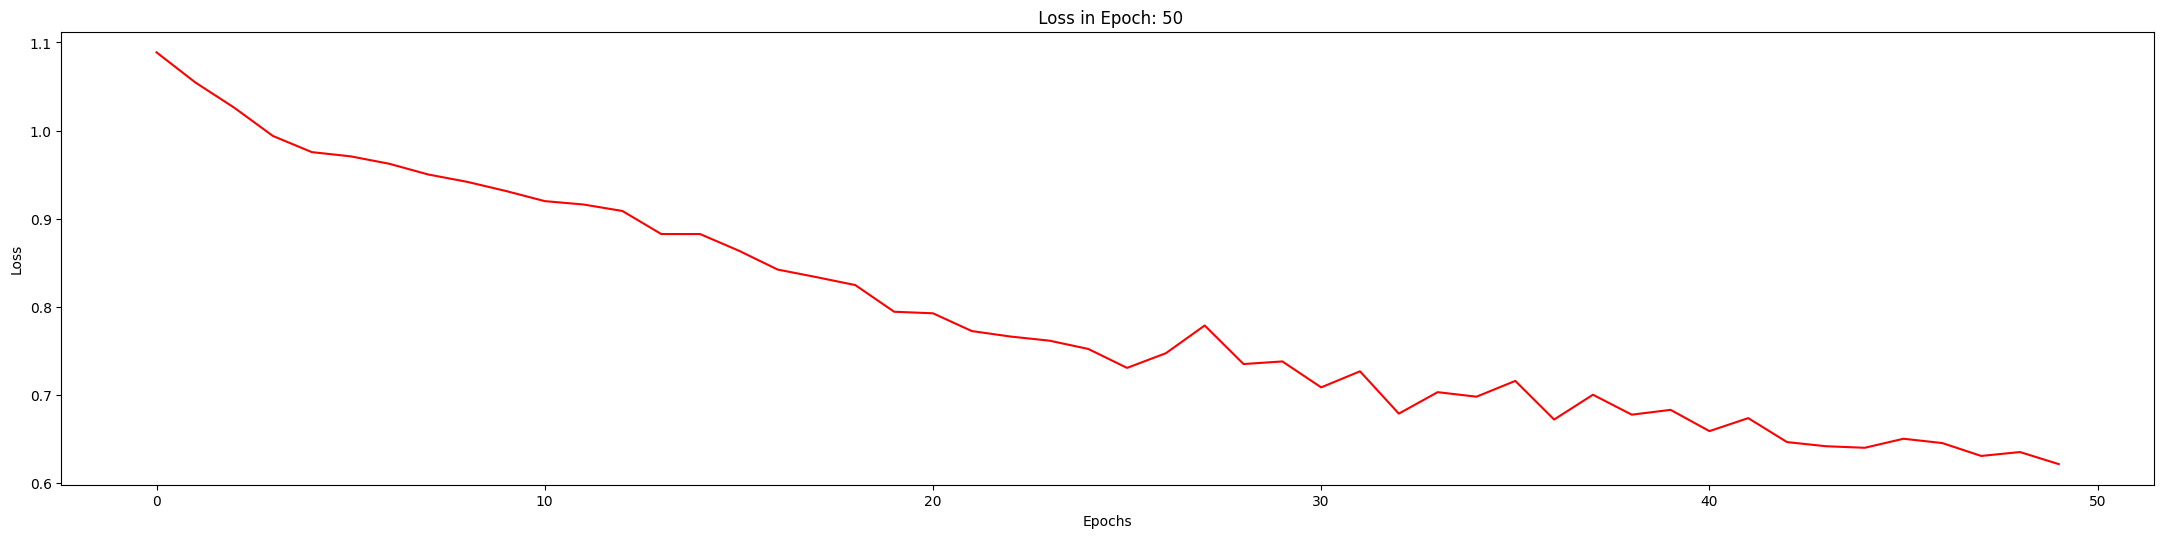

Epoch: 051, Model Loss: 0.6287
Epoch: 052, Model Loss: 0.6149
Epoch: 053, Model Loss: 0.6172
Epoch: 054, Model Loss: 0.6087
Epoch: 055, Model Loss: 0.6087
Epoch: 056, Model Loss: 0.6089
Epoch: 057, Model Loss: 0.6174
Epoch: 058, Model Loss: 0.6073
Epoch: 059, Model Loss: 0.5983
Epoch: 060, Model Loss: 0.6069
Epoch: 061, Model Loss: 0.5986
Epoch: 062, Model Loss: 0.6097
Epoch: 063, Model Loss: 0.5950
Epoch: 064, Model Loss: 0.6056
Epoch: 065, Model Loss: 0.5822
Epoch: 066, Model Loss: 0.5949
Epoch: 067, Model Loss: 0.5823
Epoch: 068, Model Loss: 0.5870
Epoch: 069, Model Loss: 0.5813
Epoch: 070, Model Loss: 0.5839
Epoch: 071, Model Loss: 0.5824
Epoch: 072, Model Loss: 0.5810
Epoch: 073, Model Loss: 0.5926
Epoch: 074, Model Loss: 0.5751
Epoch: 075, Model Loss: 0.5865
Epoch: 076, Model Loss: 0.5744
Epoch: 077, Model Loss: 0.5746
Epoch: 078, Model Loss: 0.5781
Epoch: 079, Model Loss: 0.5718
Epoch: 080, Model Loss: 0.5708
Epoch: 081, Model Loss: 0.5677
Epoch: 082, Model Loss: 0.5729
Epoch: 0

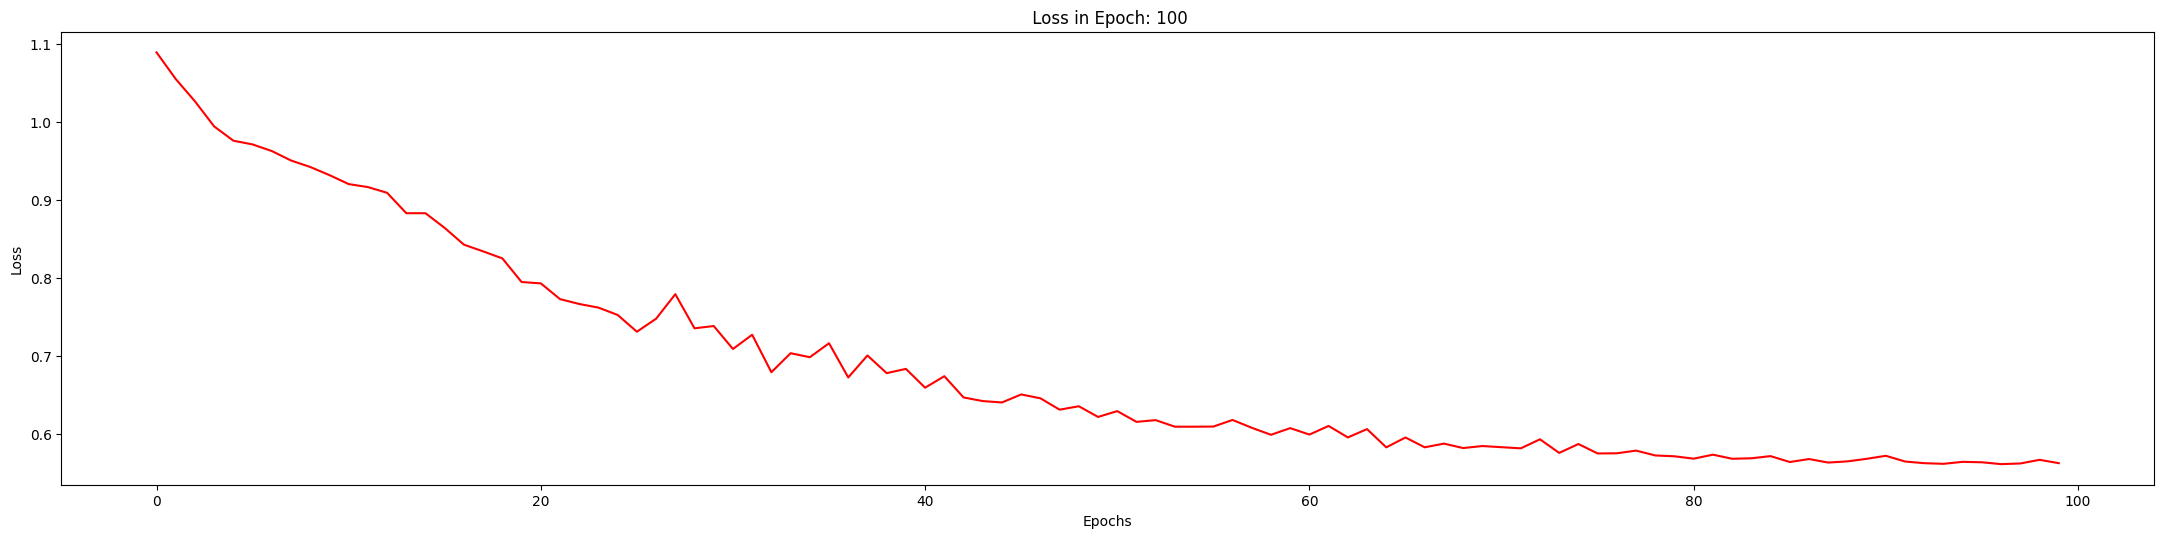

Epoch: 101, Model Loss: 0.5591
Epoch: 102, Model Loss: 0.5615
Epoch: 103, Model Loss: 0.5636
Epoch: 104, Model Loss: 0.5577
Epoch: 105, Model Loss: 0.5593
Epoch: 106, Model Loss: 0.5593
Epoch: 107, Model Loss: 0.5593
Epoch: 108, Model Loss: 0.5580
Epoch: 109, Model Loss: 0.5597
Epoch: 110, Model Loss: 0.5586
Epoch: 111, Model Loss: 0.5580
Epoch: 112, Model Loss: 0.5582
Epoch: 113, Model Loss: 0.5589
Epoch: 114, Model Loss: 0.5561
Epoch: 115, Model Loss: 0.5573
Epoch: 116, Model Loss: 0.5554
Epoch: 117, Model Loss: 0.5597
Epoch: 118, Model Loss: 0.5567
Epoch: 119, Model Loss: 0.5555
Epoch: 120, Model Loss: 0.5557
Epoch: 121, Model Loss: 0.5549
Epoch: 122, Model Loss: 0.5564
Epoch: 123, Model Loss: 0.5576
Epoch: 124, Model Loss: 0.5550
Epoch: 125, Model Loss: 0.5554
Epoch: 126, Model Loss: 0.5553
Epoch: 127, Model Loss: 0.5554
Epoch: 128, Model Loss: 0.5543
Epoch: 129, Model Loss: 0.5564
Epoch: 130, Model Loss: 0.5551
Epoch: 131, Model Loss: 0.5550
Epoch: 132, Model Loss: 0.5547
Epoch: 1

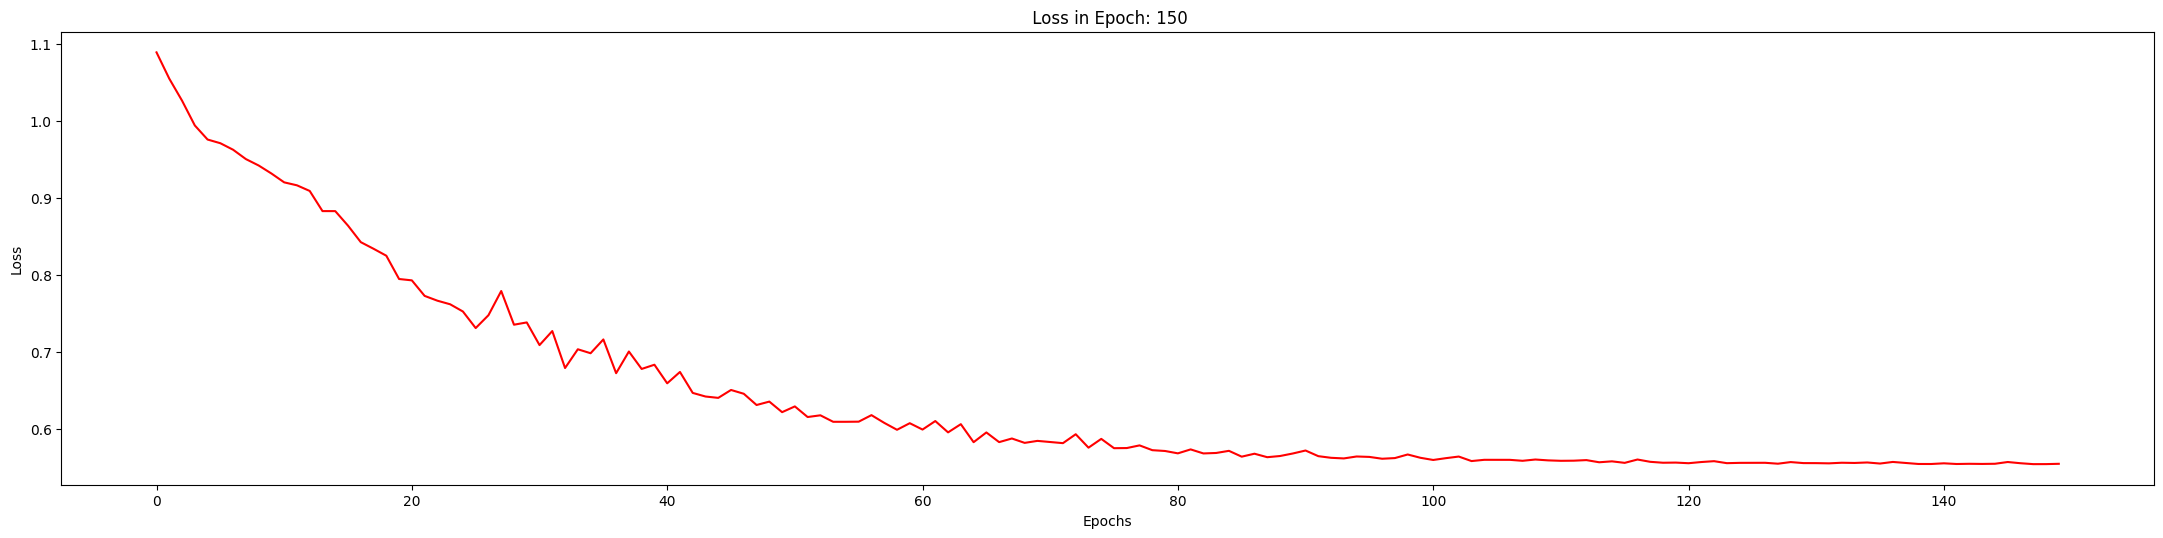

Epoch: 151, Model Loss: 0.5541
Epoch: 152, Model Loss: 0.5541
Epoch: 153, Model Loss: 0.5530
Epoch: 154, Model Loss: 0.5536
Epoch: 155, Model Loss: 0.5538
Epoch: 156, Model Loss: 0.5539
Epoch: 157, Model Loss: 0.5533
Epoch: 158, Model Loss: 0.5553
Epoch: 159, Model Loss: 0.5581
Epoch: 160, Model Loss: 0.5529
Epoch: 161, Model Loss: 0.5538
Epoch: 162, Model Loss: 0.5534
Epoch: 163, Model Loss: 0.5526
Epoch: 164, Model Loss: 0.5529
Epoch: 165, Model Loss: 0.5532
Epoch: 166, Model Loss: 0.5527
Epoch: 167, Model Loss: 0.5558
Epoch: 168, Model Loss: 0.5550
Epoch: 169, Model Loss: 0.5546
Epoch: 170, Model Loss: 0.5534
Epoch: 171, Model Loss: 0.5525
Epoch: 172, Model Loss: 0.5524
Epoch: 173, Model Loss: 0.5525
Epoch: 174, Model Loss: 0.5528
Epoch: 175, Model Loss: 0.5524
Epoch: 176, Model Loss: 0.5531
Epoch: 177, Model Loss: 0.5537
Epoch: 178, Model Loss: 0.5528
Epoch: 179, Model Loss: 0.5534
Epoch: 180, Model Loss: 0.5524
Epoch: 181, Model Loss: 0.5532
Epoch: 182, Model Loss: 0.5528
Epoch: 1

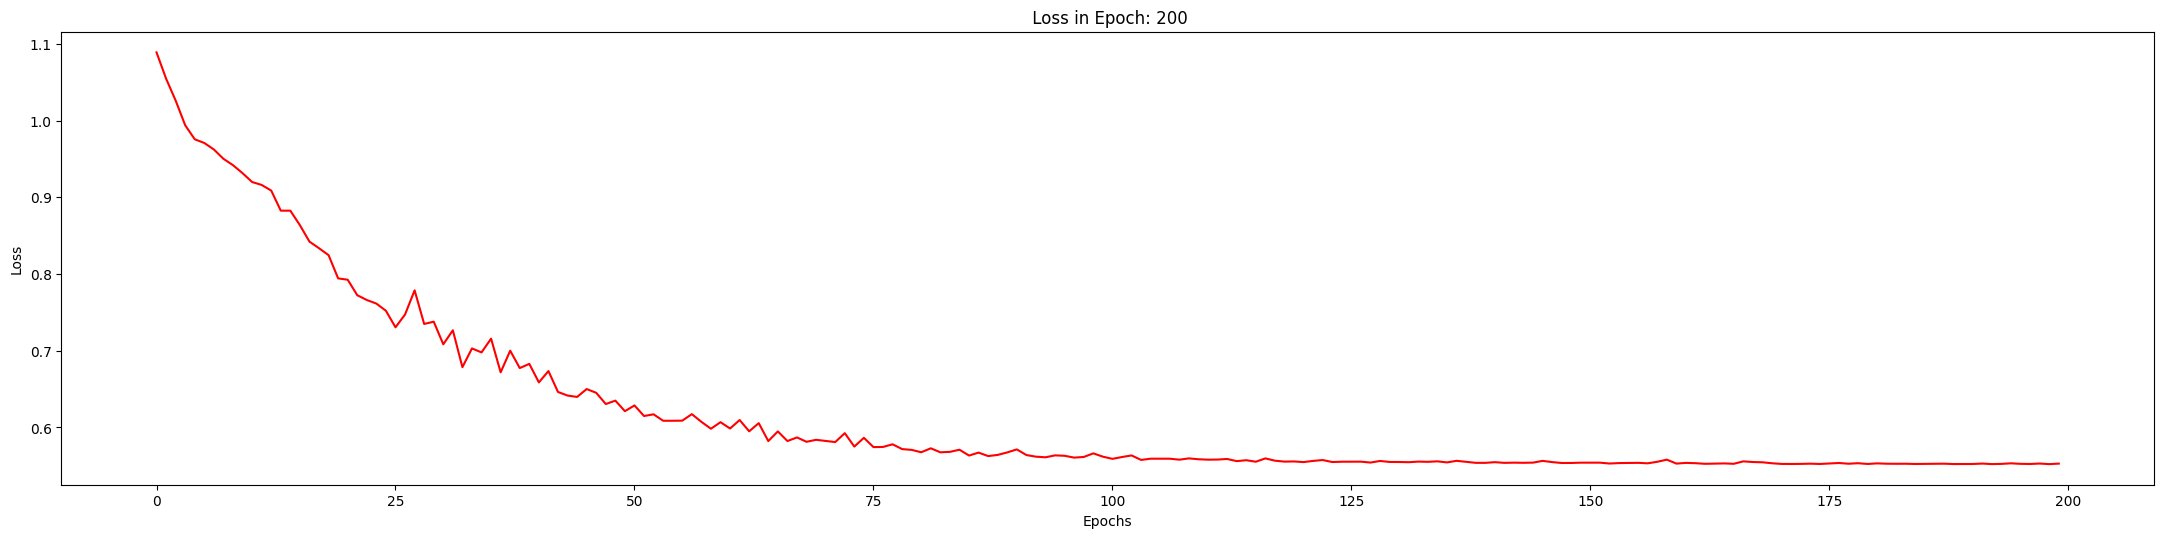

Epoch: 201, Model Loss: 0.5525
Epoch: 202, Model Loss: 0.5524
Epoch: 203, Model Loss: 0.5525
Epoch: 204, Model Loss: 0.5523
Epoch: 205, Model Loss: 0.5520
Epoch: 206, Model Loss: 0.5521
Epoch: 207, Model Loss: 0.5522
Epoch: 208, Model Loss: 0.5522
Epoch: 209, Model Loss: 0.5529
Epoch: 210, Model Loss: 0.5524
Epoch: 211, Model Loss: 0.5527
Epoch: 212, Model Loss: 0.5526
Epoch: 213, Model Loss: 0.5521
Epoch: 214, Model Loss: 0.5523
Epoch: 215, Model Loss: 0.5528
Epoch: 216, Model Loss: 0.5525
Epoch: 217, Model Loss: 0.5527
Epoch: 218, Model Loss: 0.5522
Epoch: 219, Model Loss: 0.5526
Epoch: 220, Model Loss: 0.5527
Epoch: 221, Model Loss: 0.5522
Epoch: 222, Model Loss: 0.5522
Epoch: 223, Model Loss: 0.5521
Epoch: 224, Model Loss: 0.5525
Epoch: 225, Model Loss: 0.5521
Epoch: 226, Model Loss: 0.5523
Epoch: 227, Model Loss: 0.5521
Epoch: 228, Model Loss: 0.5521
Epoch: 229, Model Loss: 0.5521
Epoch: 230, Model Loss: 0.5525
Epoch: 231, Model Loss: 0.5524
Epoch: 232, Model Loss: 0.5522
Epoch: 2

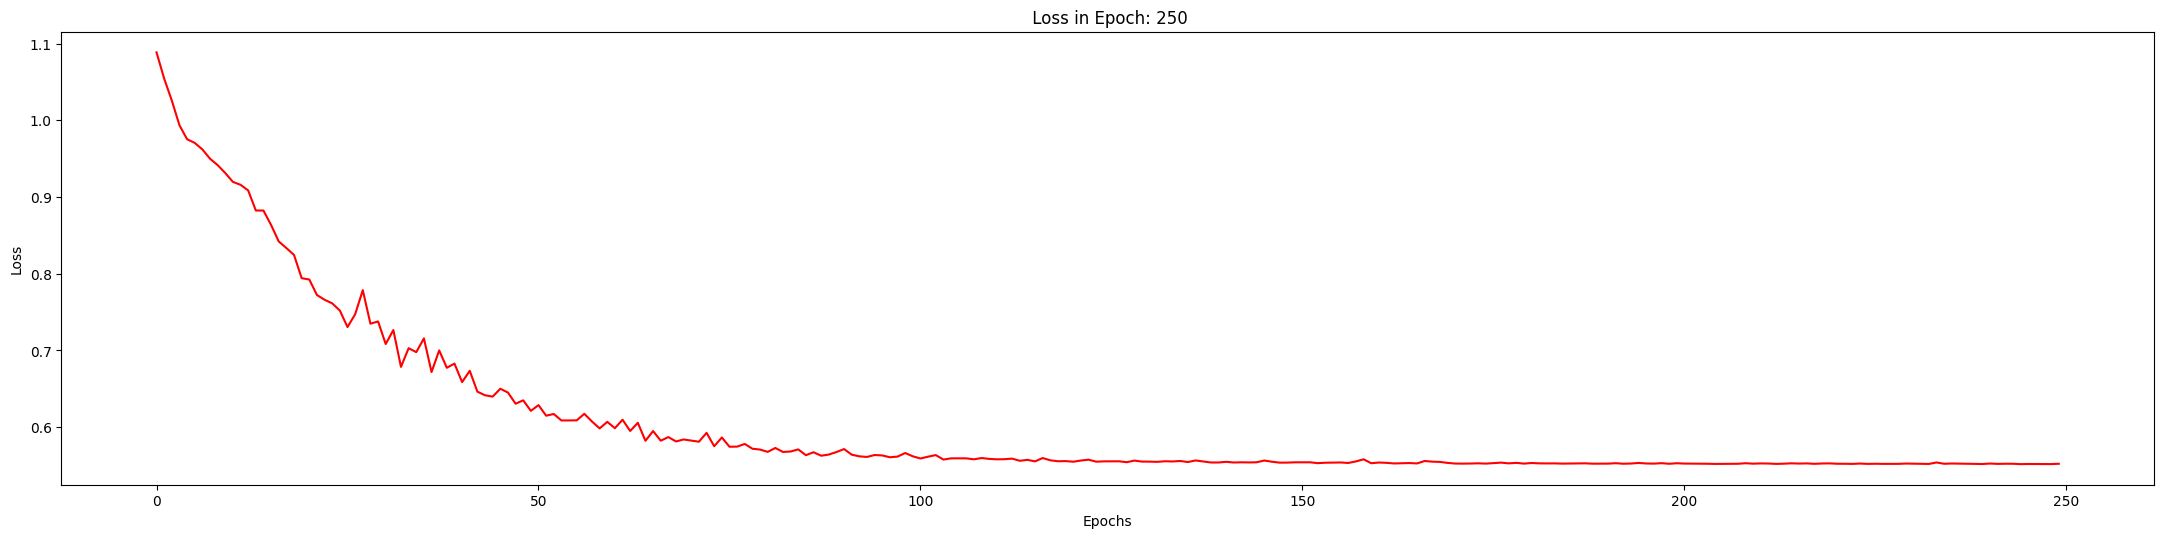

Epoch: 251, Model Loss: 0.5518
Epoch: 252, Model Loss: 0.5519
Epoch: 253, Model Loss: 0.5520
Epoch: 254, Model Loss: 0.5518
Epoch: 255, Model Loss: 0.5518
Epoch: 256, Model Loss: 0.5521
Epoch: 257, Model Loss: 0.5520
Epoch: 258, Model Loss: 0.5518
Epoch: 259, Model Loss: 0.5520
Epoch: 260, Model Loss: 0.5521
Epoch: 261, Model Loss: 0.5521
Epoch: 262, Model Loss: 0.5518
Epoch: 263, Model Loss: 0.5518
Epoch: 264, Model Loss: 0.5519
Epoch: 265, Model Loss: 0.5518
Epoch: 266, Model Loss: 0.5518
Epoch: 267, Model Loss: 0.5519
Epoch: 268, Model Loss: 0.5521
Epoch: 269, Model Loss: 0.5519
Epoch: 270, Model Loss: 0.5517
Epoch: 271, Model Loss: 0.5520
Epoch: 272, Model Loss: 0.5518
Epoch: 273, Model Loss: 0.5518
Epoch: 274, Model Loss: 0.5521
Epoch: 275, Model Loss: 0.5520
Epoch: 276, Model Loss: 0.5519
Epoch: 277, Model Loss: 0.5519
Epoch: 278, Model Loss: 0.5518
Epoch: 279, Model Loss: 0.5519
Epoch: 280, Model Loss: 0.5517
Epoch: 281, Model Loss: 0.5519
Epoch: 282, Model Loss: 0.5518
Epoch: 2

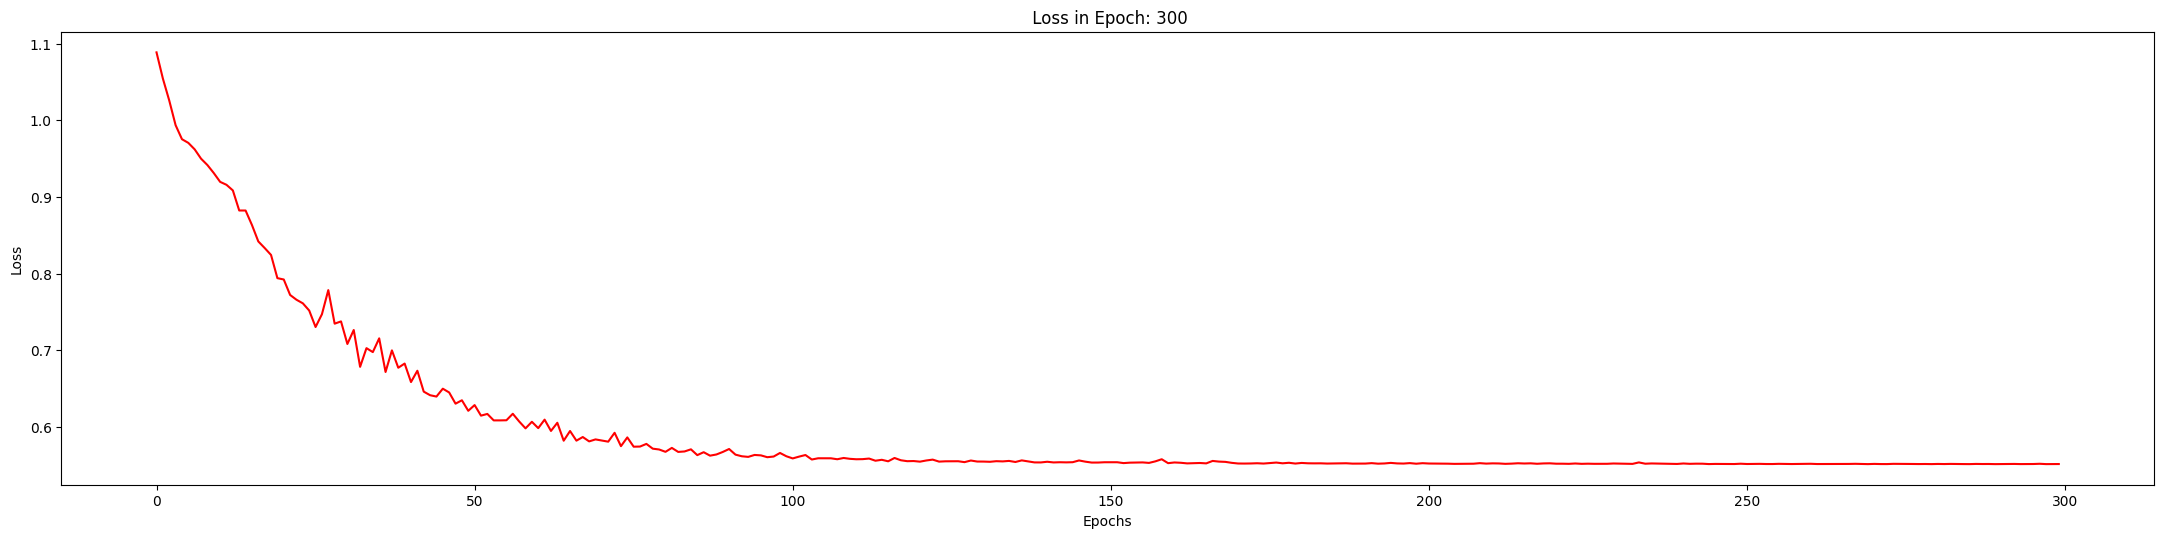

In [ ]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index, fake_train_dataloader)

In [ ]:
GNN_Model_test_predicted_labels = []
def GNN_Model_test(test_loader):
    GNN_Model.eval()
    correct = 0

    for batch_of_graphs in test_loader:
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            GNN_Model_test_pred = soft.argmax(dim=1)
        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = GNN_Model(batch_of_graphs, None)
            GNN_Model_test_pred = soft.argmax(dim=1)
        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, before_soft, soft = GNN_Model(batch_of_graphs, None)
            GNN_Model_test_pred = soft.argmax(dim=1)
        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batch_of_graphs, None)
            GNN_Model_test_pred = soft.argmax(dim=1)

        GNN_Model_test_predicted_labels.append(GNN_Model_test_pred.tolist()[0])
        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())
    return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [ ]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(fake_test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 1.0000


In [ ]:
print(GNN_Model)
test_dataloader_example = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)
for batch in test_dataloader_example:
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch)
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch)
    break
#print(softmaxed_h2)
print(soft)
#print(train_dataset[0].x)

GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-2): 3 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward0>)


In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
samples_time = instance_time(mutag_test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.005671323000569828, 0.0034693289999268018, 0.004255916001056903, 0.004825193000215222, 0.00444591700033925, 0.003392046999579179, 0.0034554750000097556, 0.003525554999214364, 0.0038221689992496977, 0.0035074790012004087, 0.0036691850000352133, 0.003507082999931299, 0.0035746920002566185, 0.003477162999843131, 0.0036923299994668923, 0.0042735349998110905, 0.0035885329998563975, 0.0035711379987333203, 0.0035099979995720787, 0.0033490879995952128, 0.004050984998684726, 0.0037046329998702276, 0.003648277999673155, 0.0032939709999482147, 0.002784704000077909, 0.0026876750016526785, 0.007830049999029143, 0.003475329000139027, 0.002796257998852525, 0.0028567579993250547, 0.002775337999992189, 0.004296938999686972, 0.0059904469999310095, 0.0030713590003870195, 0.0029802570006722817, 0.0027532979984243866, 0.0030544159999408294, 0.002883315000872244]


In [ ]:
real_labels = []
for graph in mutag_test_dataloader:
    real_labels.append(graph.y.tolist()[0])

In [ ]:
print("predicted_labels: ", predicted_labels)
print("real_labels: ", real_labels)
print("Test Accuracy: ", metrics.accuracy_score(real_labels, predicted_labels))

predicted_labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
real_labels:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Test Accuracy:  0.3684210526315789


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predicted_labels)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predicted_labels)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predicted_labels, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predicted_labels, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.5 Auc_Prc:  0.8157894736842105 Acc:  0.3684210526315789 Acc2:  14


In [ ]:
import torch
from torch.nn.parameter import Parameter
import numpy as np
from torch import sigmoid

class HardConcrete(torch.nn.Module):

    def __init__(self, beta=1 / 3, gamma=-0.2, zeta=1.0, fix_temp=True, loc_bias=3):
        super(HardConcrete, self).__init__()

        self.temp = beta if fix_temp else Parameter(torch.zeros(1).fill_(beta))
        self.gamma = gamma
        self.zeta = zeta
        self.gamma_zeta_ratio = np.math.log(-gamma / zeta)

        self.loc_bias = loc_bias

    def forward(self, input_element, summarize_penalty=True):
        input_element = input_element + self.loc_bias

        if self.training:
            u = torch.empty_like(input_element).uniform_(1e-6, 1.0-1e-6)

            s = sigmoid((torch.log(u) - torch.log(1 - u) + input_element) / self.temp)

            penalty = sigmoid(input_element - self.temp * self.gamma_zeta_ratio)
            penalty = penalty
        else:
            s = sigmoid(input_element)
            penalty = torch.zeros_like(input_element)

        if summarize_penalty:
            penalty = penalty.mean()

        s = s * (self.zeta - self.gamma) + self.gamma

        clipped_s = self.clip(s)

        if True:
            hard_concrete = (clipped_s > 0.5).float()
            clipped_s = clipped_s + (hard_concrete - clipped_s).detach()

        return clipped_s, penalty

    def clip(self, x, min_val=0, max_val=1):
        return x.clamp(min_val, max_val)

In [ ]:

class GraphMask:
    def __init__(self, GNN_Model, explainer_save_index, Exp_Epoch, Exp_lr, explainer_hid_dim, node_feat_dim):

        ######################              MAIN
        self.beta = 1 / 3
        self.gamma = -0.2
        self.zeta = 1.0
        self.fix_temp = True
        self.loc_bias=3
        self.penalty_scaling = 1
        self.allowance = 0.03
        self.max_allowed_performance_diff = 0.05
        self.temp = self.beta if self.fix_temp else Parameter(torch.zeros(1).fill_(self.beta))
        self.gamma_zeta_ratio = math.log(-self.gamma / self.zeta)
        ###########
        self.GNN_Model = GNN_Model
        self.node_feat_dim = node_feat_dim
        self.explainer_lr = Exp_lr
        self.explainer_hid_dim = explainer_hid_dim
        self.graphmask_mlp = Sequential(Linear(self.node_feat_dim * 2, self.explainer_hid_dim), LayerNorm(self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        self.graphmask_mlp_optimizer = torch.optim.Adam(self.graphmask_mlp.parameters(), lr=self.explainer_lr)
        self.explainer_epochs = Exp_Epoch
        #self.criterion = torch.nn.CrossEntropyLoss()
        #self.criterion = F.binary_cross_entropy_with_logits
        self.criterion = nn.L1Loss()
        self.explainer_save_index = explainer_save_index
        self.Explainability_name = 'GraphMask'
        self.Task_name = 'Graph Classification'
        self.Model_Name = GNN_Model.__class__.__name__

        self.baseline = torch.FloatTensor(1)
        bl_stdv = 1. / math.sqrt(1)
        self.baseline.uniform_(-bl_stdv, bl_stdv)
        self.baseline = torch.nn.Parameter(self.baseline, requires_grad=True)

        ###############.      Lagrangian Optimization
        self.min_alpha = -2
        self.max_alpha = 30
        self.update_counter = 0
        self.init_alpha = 0.55
        self.alpha_optimizer_lr=1e-2
        self.alpha = torch.tensor(self.init_alpha, requires_grad=True)
        self.optimizer_alpha = torch.optim.RMSprop([self.alpha], lr=self.alpha_optimizer_lr, centered=True)
        self.update_counter = 0


    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        loss_per_epoch = self.criterion(By_Perturbation_predicted_label, predicted_label)
        return loss_per_epoch

    def binary_concrete(self, explaier_outputs, temperature, summarize_penalty=True):
        explaier_outputs = explaier_outputs + self.loc_bias
        if self.ExTrain_or_ExTest == 'train':
            u = torch.empty_like(explaier_outputs).uniform_(1e-6, 1.0-1e-6)
            s = sigmoid((torch.log(u) - torch.log(1 - u) + explaier_outputs) / temperature)
            penalty = sigmoid(explaier_outputs - temperature * self.gamma_zeta_ratio)
        else:
            s = sigmoid(explaier_outputs)
            penalty = torch.zeros_like(explaier_outputs)

        if summarize_penalty:
            penalty = penalty.mean()

        s = s * (self.zeta - self.gamma) + self.gamma
        clipped_s = s.clamp(min=0, max=1)

        hard_concrete = (clipped_s > 0.5).float()
        clipped_s = clipped_s + (hard_concrete - clipped_s).detach()
        clipped_s = clipped_s.squeeze(dim=-1)

        return clipped_s, penalty

    def lagrangian_optimization_update(self, f, g, batch_size_multiplier):

        if batch_size_multiplier is not None and batch_size_multiplier > 1:
            if self.update_counter % batch_size_multiplier == 0:
                self.graphmask_mlp_optimizer.zero_grad()
                self.optimizer_alpha.zero_grad()

            self.update_counter += 1
        else:
            self.graphmask_mlp_optimizer.zero_grad()
            self.optimizer_alpha.zero_grad()

        loss = f + torch.nn.functional.softplus(self.alpha) * g
        loss.backward(retain_graph=True)

        if batch_size_multiplier is not None and batch_size_multiplier > 1:
            if self.update_counter % batch_size_multiplier == 0:
                self.graphmask_mlp_optimizer.step()
                self.alpha.grad *= -1
                self.optimizer_alpha.step()
        else:
            self.graphmask_mlp_optimizer.step()
            self.alpha.grad *= -1
            self.optimizer_alpha.step()

        if self.alpha.item() < -2:
            self.alpha.data = torch.full_like(self.alpha.data, -2)
        elif self.alpha.item() > 30:
            self.alpha.data = torch.full_like(self.alpha.data, 30)

    def train_step_explainer(self, merged_embeddings_list_batchs, GNN_Model, your_dataset, GNN_Model_preds_NOT_MASKED, target_class):

        self.graphmask_mlp.train()
        self.graphmask_mlp.zero_grad()
        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explaier_outputs = self.graphmask_mlp(batched_merged_embeddings).view(-1)

            edge_mask, sparsity_penalty = self.binary_concrete(explaier_outputs, self.temp)

            importance_indices = edge_mask == 0
            edge_mask[importance_indices] = self.baseline

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_MASKED = GNN_Model(batched_graphs)

            elif GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())

            elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, before_soft, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())

            elif GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())

            batch_loss = self.explainer_loss(soft_MASKED.detach()[:,target_class].to(torch.float32), batched_preds_NOT_MASKED.detach()[:,target_class].to(torch.float32))

            g = torch.relu(batch_loss - self.allowance).mean()
            f = (sparsity_penalty * self.penalty_scaling)

            try:
                batch_size = your_dataset.batch_size
            except:
                batch_size = 1

            self.lagrangian_optimization_update(f=f, g=g, batch_size_multiplier=batch_size)

            batch_loss.requires_grad = True
            batch_loss.backward(retain_graph=True)
            self.graphmask_mlp_optimizer.step()

        return edge_mask

    def train_explainer(self, GNN_Model, your_dataset, target_class):
        edge_masks_per_epoch = []
        your_dataset2 = deepcopy(your_dataset)
        merged_embeddings_list = self.get_merged_embeddings(GNN_Model, your_dataset)

        GNN_Model_preds_NOT_MASKED = []
        for batch_of_graphs in your_dataset:

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, before_soft, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)

            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

        for epoch in range(self.explainer_epochs):
            print("Epoch: ", epoch)
            edge_mask = self.train_step_explainer(merged_embeddings_list, GNN_Model, your_dataset, GNN_Model_preds_NOT_MASKED, target_class)
            edge_masks_per_epoch.append(edge_mask)


            if (epoch + 1) == self.explainer_save_index:
                torch.save({'epoch': epoch+1, 'model_state_dict': self.graphmask_mlp.state_dict(), 'optimizer_state_dict': self.graphmask_mlp_optimizer.state_dict(), 'baseline_state_dict': self.baseline}, "/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(epoch + 1) + "_epochs_" + str(target_class) + ".pt")
        if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            self.clear_masks(GNN_Model)

    def test_explainer(self, GNN_Model, your_dataset, graphmask_mlp, target_class):
        edge_masks = []
        predicted_labels_MASKED = []
        merged_embeddings_list_batchs = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        graphmask_mlp.eval()
        for batch_of_graphs in your_dataset:

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_NOT_MASKED = GNN_Model(batch_of_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_NOT_MASKED = GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, before_soft, soft_NOT_MASKED = GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = GNN_Model(batch_of_graphs, None)

            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explaier_outputs = graphmask_mlp(batched_merged_embeddings).view(-1)

            edge_masks.append(explaier_outputs)

            edge_mask, sparsity_penalty = self.binary_concrete(explaier_outputs, self.temp)

            importance_indices = edge_mask == 0
            edge_mask[importance_indices] = self.baseline

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_MASKED = GNN_Model(batched_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, before_soft, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = GNN_Model(batched_graphs, edge_mask.tolist())

            predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.detach()[:,target_class].to(torch.float32)).tolist())
        self.clear_masks(self.GNN_Model)
        normalized_scores = self.normalize_scores(edge_masks)
        standardized_scores = self.standardize_scores(normalized_scores)

        return predicted_labels_MASKED, standardized_scores

    def normalize_scores(self, Edge_Masks_original):
        graphs=[]
        for graph_masks in Edge_Masks_original:
            temp = []
            for edge_mask in graph_masks.tolist():
                #print((edge_mask - min(graph_masks)) * 100)/((max(graph_masks) - min(graph_masks)))
                temp.append((edge_mask - min(graph_masks)) * 100/(max(graph_masks) - min(graph_masks)))
            graphs.append(torch.stack(temp))
        return graphs

    def standardize_scores(self, Edge_Masks_original):
        graphs=[]
        for graph_masks in Edge_Masks_original:
            temp = []
            for edge_mask in graph_masks:
                #print((edge_mask - min(graph_masks)) * 100)/((max(graph_masks) - min(graph_masks)))
                temp.append(edge_mask/max(graph_masks))
            graphs.append(torch.stack(temp))
        return graphs

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid
                #print(module._edge_mask)

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def batch_handler_for_embeddings(self, batched_graphs, new_embeddings):
        unpaded_data = []
        #if batched_graphs.batch is not None:
        #    graph_sizes = [batched_graphs[i].x.size()[1] for i in range(len(batched_graphs))]
        #else:
        #    graph_sizes = [len(batched_graphs.x)]

        #for i, graph in enumerate(new_embeddings):
        #    unpaded_data.append(graph[:graph_sizes[i]])
        #new_graph_embeddings_merged = torch.cat(unpaded_data, dim=0)
        for i, graph in enumerate(new_embeddings):
            unpaded_data.append(graph)
        new_graph_embeddings_merged = torch.cat(unpaded_data, dim=0)
        return new_graph_embeddings_merged

    def get_merged_embeddings(self, GNN_Model, your_dataset):
        new_embeddings_list = []
        edge_embeddings_list = []
        for batched_graphs in your_dataset:
            new_graph_by_masks = deepcopy(batched_graphs.detach())

            new_embeddings, GNN_Model_explain_predicted_labels = self.get_hopped_embeddings(GNN_Model, new_graph_by_masks)

            new_embeddings_list.append(new_embeddings)
            if len(new_embeddings.size()) == 3: #and new_embeddings.size()[0] > 1:
                new_graph_embeddings_updated = self.batch_handler_for_embeddings(batched_graphs, new_embeddings)
                edge_embeddings = self.edge_embeddings_generator(new_graph_embeddings_updated, deepcopy(batched_graphs.edge_index))
            else:
                edge_embeddings = self.edge_embeddings_generator(new_embeddings, deepcopy(batched_graphs.edge_index))

            edge_embeddings_list.append(edge_embeddings)

        return edge_embeddings_list


    def edge_embeddings_generator(self, embedding, edge_index):
        Zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
        edge_embds = torch.cat(Zs, dim=-1)

        return edge_embds

    def get_hopped_embeddings(self, GNN_Model, batch_of_graphs):
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            return Output_of_Hidden_Layers[-1], soft.argmax(dim=1)

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = GNN_Model(batch_of_graphs, None)
            return final_GNN_layer_output, soft.argmax(dim=1)

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, before_soft, soft = GNN_Model(batch_of_graphs, None)
            return batch_of_graphs.x, soft.argmax(dim=1)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batch_of_graphs, None)
            return torch.squeeze(mlps_output_embeds[-1], dim=0), soft.argmax(dim=1)


    def load_explainer_mlp(self, Exp_Load_index, target_class):
        graphmask_mlp = Sequential(Linear(self.node_feat_dim * 2, self.explainer_hid_dim), LayerNorm(self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        graphmask_mlp_optimizer = torch.optim.Adam(self.graphmask_mlp.parameters(), lr=self.explainer_lr)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(Exp_Load_index)+"_epochs_" + str(target_class) + ".pt")
        graphmask_mlp.load_state_dict(checkpoint['model_state_dict'])
        graphmask_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        baseline = checkpoint['baseline_state_dict']
        #print("BaseLine: ", target_class, "   ", baseline)




        return graphmask_mlp, graphmask_mlp_optimizer, baseline

    def __call__(self, ExTrain_or_ExTest,  Exp_Load_index, your_dataset, target_class):
        self.ExTrain_or_ExTest = ExTrain_or_ExTest
        if ExTrain_or_ExTest == "train":
            #t1 = perf_counter()
            self.train_explainer(self.GNN_Model, your_dataset, target_class)
            #t2 = perf_counter()
            #print((t2 - t1) / len(your_dataset))
        elif ExTrain_or_ExTest == "test":
            graphmask_mlp, graphmask_mlp_optimizer, baseline = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class=target_class)
            predicted_labels, edge_masks = self.test_explainer(self.GNN_Model, your_dataset, graphmask_mlp, target_class)
            print("Class: ", target_class, " predicted_labels: ", predicted_labels)
            print("masks: ", len(edge_masks), edge_masks[0])
            return edge_masks

        else:
            print("recheck")


target_class = 0
ExTrain_or_ExTest = 'test'


t1_start = perf_counter()
EXP = GraphMask(GNN_Model=GNN_Model, explainer_save_index=2, Exp_Epoch=2, Exp_lr=0.001, explainer_hid_dim=7, node_feat_dim=13)
test_edge_masks = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=2, your_dataset=[fake_test_dataset[-1]], target_class=target_class)
t2_start = perf_counter()
attribution_time = (t2_start - t1_start)/len(fake_train_dataset if ExTrain_or_ExTest == 'train' else fake_test_dataset)
print("attribution_time: ", attribution_time)


# test on one sample in a list: [fake_test_dataset[-1]], train could be done by both sample-based and batch-based.

Class:  0  predicted_labels:  [0.06631350517272949]
masks:  1 tensor([0.5503, 0.2991, 0.6883, 0.1969, 0.5529, 0.4055, 0.8322, 1.0000, 0.4183,
        0.1975, 0.4152, 0.5399, 0.1128, 0.0056, 0.0144, 0.0788, 0.0415, 0.0375,
        0.0071, 0.1553, 0.0421, 0.0410, 0.1335, 0.2186, 0.0769, 0.0181, 0.0422,
        0.0339, 0.0417, 0.1786, 0.1099, 0.2660, 0.0241, 0.1822, 0.0986, 0.1861,
        0.3607, 0.4842, 0.0236, 0.2622, 0.1145, 0.1861, 0.0737, 0.0014, 0.1375,
        0.0785, 0.2342, 0.0836, 0.0181, 0.2083, 0.3118, 0.0319, 0.0880, 0.1518,
        0.0108, 0.0309, 0.0401, 0.1835, 0.0058, 0.0236, 0.0092, 0.0098, 0.0035,
        0.0884, 0.0147, 0.0840, 0.1348, 0.0191, 0.0430, 0.0855, 0.0303, 0.0066,
        0.0122, 0.0148, 0.0519, 0.3134, 0.1270, 0.2034, 0.5682, 0.5425, 0.2147,
        0.3231, 0.4394, 0.4205, 0.2124, 0.3212, 0.3068, 0.1139, 0.0287, 0.0036,
        0.0119, 0.0725, 0.1484, 0.0378, 0.0427, 0.1255, 0.2099, 0.0852, 0.0401,
        0.0707, 0.0158, 0.0379, 0.0293, 0.0575, 0.0939, 0.

In [ ]:
# GCN_plus_GAP ==>>> class 0 ==>>> 8.28 nodes
# GCN_plus_GAP ==>>> class 1 ==>>> 9.34 nodes
node_index_list = []
threshold = 0.5
for i, explanation in enumerate(test_edge_masks):

    indices = torch.nonzero(explanation > threshold).squeeze()
    if indices.dim() == 0:
        indices = indices.unsqueeze(0)
    indices_list = indices.tolist()
    sources = mutag_test_dataset[i].edge_index[0][indices_list].tolist()
    targets = mutag_test_dataset[i].edge_index[1][indices_list].tolist()

    whole = sources + targets
    whole_no_repeat = list(set(whole))
    node_index_list.append(whole_no_repeat)
size_list = []
for list1 in node_index_list:
    size_list.append(len(list1))
print(statistics.mean(size_list))

9.342105263157896


In [ ]:
# DGCNN ==>>> class 0 ==>>> 12.57 nodes
# DGCNN ==>>> class 1 ==>>> 12.42 nodes
node_index_list = []
threshold = 0.5
for i, explanation in enumerate(test_edge_masks):

    indices = torch.nonzero(explanation > threshold).squeeze()
    if indices.dim() == 0:
        indices = indices.unsqueeze(0)
    indices_list = indices.tolist()
    sources = mutag_test_dataset[i].edge_index[0][indices_list].tolist()
    targets = mutag_test_dataset[i].edge_index[1][indices_list].tolist()

    whole = sources + targets
    whole_no_repeat = list(set(whole))
    node_index_list.append(whole_no_repeat)
size_list = []
for list1 in node_index_list:
    size_list.append(len(list1))
print(statistics.mean(size_list))

12.421052631578947


In [ ]:
# DIFFPOOL ==>>> class 0 ==>>> 9.05  nodes
# DIFFPOOL ==>>> class 1 ==>>> 13.84 nodes

node_index_list = []
threshold = 0.5
for i, explanation in enumerate(test_edge_masks):

    indices = torch.nonzero(explanation > threshold).squeeze()
    if indices.dim() == 0:
        indices = indices.unsqueeze(0)
    indices_list = indices.tolist()
    sources = mutag_test_dataset[i].edge_index[0][indices_list].tolist()
    targets = mutag_test_dataset[i].edge_index[1][indices_list].tolist()

    whole = sources + targets
    whole_no_repeat = list(set(whole))
    node_index_list.append(whole_no_repeat)
size_list = []
for list1 in node_index_list:
    size_list.append(len(list1))
print(statistics.mean(size_list))

13.842105263157896


In [ ]:
# GIN ==>>> class 0 ==>>> 9.05 nodes
# GIN ==>>> class 1 ==>>> 7.21 nodes

node_index_list = []
threshold = 0.5
for i, explanation in enumerate(test_edge_masks):

    indices = torch.nonzero(explanation > threshold).squeeze()
    if indices.dim() == 0:
        indices = indices.unsqueeze(0)
    indices_list = indices.tolist()
    sources = mutag_test_dataset[i].edge_index[0][indices_list].tolist()
    targets = mutag_test_dataset[i].edge_index[1][indices_list].tolist()

    whole = sources + targets
    whole_no_repeat = list(set(whole))
    node_index_list.append(whole_no_repeat)
size_list = []
for list1 in node_index_list:
    size_list.append(len(list1))
print(statistics.mean(size_list))

9.052631578947368
